For complex tasks, a single agent can struggle. A task like "Research the latest AI advancements and write a blog post" requires multiple skills: searching, reading, synthesizing, and writing. The supervisor pattern addresses this by creating a team of specialized "worker" agents managed by one "supervisor" agent.

<ol><li>Supervisor: A "project manager" LLM that breaks down a complex request and delegates sub-tasks to the best worker for the job.</li>

<li>Workers: Specialized agents (or even simple, tool-using nodes) that are experts in one area, like searching the web or writing code.</li></ol>

**flow is loop**: The supervisor analyzes the state and routes to a worker. The worker completes its task, returns its findings to the state, and the flow returns to the supervisor to decide the next step.

In [64]:
import os
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
import json
from dotenv import load_dotenv
load_dotenv()

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0, gemini_api_key=os.getenv("GOOGLE_API_KEY"))
tool=TavilySearchResults(max_results=1)

class NewsResearcher(TypedDict):
    messages:Annotated[List[BaseMessage], add_messages]

Unexpected argument 'gemini_api_key' provided to ChatGoogleGenerativeAI. Did you mean: 'google_api_key'?
c:\Users\ujwal\OneDrive\Documents\GitHub\LangGraph\venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: UserWarning: WARNING! gemini_api_key is not default parameter.
                gemini_api_key was transferred to model_kwargs.
                Please confirm that gemini_api_key is what you intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [65]:
def get_news(state:NewsResearcher):
    """retrive search results for the given query"""
    query=state['messages'][-1].content
    retrieved_docs = tool.invoke({"query": query})
    docs= "\n\n".join(str(d) for d in retrieved_docs)
    return {"messages":[HumanMessage(content=docs, name="Retriever")]}

In [66]:
def is_relevant(state:NewsResearcher):
    """assess if the retrieved information is relevant to the query"""
    query=state['messages'][-2].content
    retrieved_docs = state['messages'][-1].content
    
    assess_prompt = f"""You are a sessment agent who assesses if the inforation is relvent to the users query
    query:{query}
    docs:{retrieved_docs}
    output a json with two keys:
    1. 'is_relevant': a boolean indicating if the documents are relevant.
    2. 'new_query': a string with a rewritten, more specific search query if and only if the is_revlevant is False"""
    
    response = model.invoke([
        SystemMessage(content="You are a relevance assessor."),
        HumanMessage(content=assess_prompt)
    ])
    return {'messages':[HumanMessage(content=response.content, name="Assessor")]}

In [67]:
def ans_generator(state: NewsResearcher):
    """Generate a final answer based on the user's query and the retrieved documents."""
    
    original_query = state['messages'][0].content
   
    retrieved_docs = state['messages'][-2].content

    prompt = f"""You are a final answer generator.
    Based on the user's query and the provided documents, write a comprehensive answer.

    User Query: {original_query}

    Retrieved Documents:
    {retrieved_docs}
    """
    response = model.invoke(prompt)
    
    return {"messages": [response]}

In [68]:
def parse_json(response_str: str):
    """
    Removes markdown code fences (e.g. ```json ... ```) and parses the remaining JSON.
    """
    content = response_str.strip()
    if content.startswith("```"):
        lines = content.splitlines()
        # Remove first line if it starts with ```
        if lines[0].startswith("```"):
            lines = lines[1:]
        # Remove last line if it starts with ```
        if lines and lines[-1].startswith("```"):
            lines = lines[:-1]
        content = "\n".join(lines).strip()
    return json.loads(content)

In [69]:
def router(state:NewsResearcher):
    """Routes based on the relevance assessment."""
    assessment_message = state['messages'][-1].content
    try:
        assessment_message = parse_json(assessment_message)
        if assessment_message['is_relevant']:
            return "generate"
        else:
            new_query = assessment_message['new_query']
            add_messages(state['messages'], [HumanMessage(content=new_query)])
            return "retrieve"
    except (json.JSONDecodeError, KeyError):
        return "end"

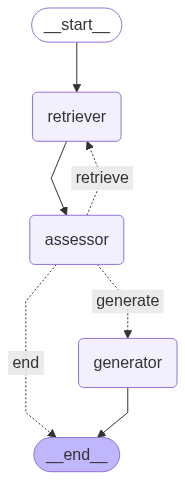

In [70]:
news_graph= StateGraph(NewsResearcher)
news_graph.add_node("retriever", get_news)
news_graph.add_node("assessor", is_relevant)
news_graph.add_node("generator", ans_generator)
news_graph.set_entry_point("retriever")

news_graph.add_conditional_edges(
    "assessor",
    router,
    {
        "generate": "generator",
        "retrieve": "retriever",
        "end":END
    }    
)

news_graph.add_edge("retriever", "assessor")
graph=news_graph.compile()
graph


In [71]:
initial_question = "What are the latest developments in AI research?"
events = graph.stream(
    {"messages": [HumanMessage(content=initial_question)]},
    stream_mode="values"
)
event_arr=[]
for event in events:
    print("\n" + "="*40)
    print("Current State:")
    # We can inspect the full state object as it flows through the graph
    print(event)
    event_arr.append(event)
print(event_arr[-1]['messages'][-1].content)



Current State:
{'messages': [HumanMessage(content='What are the latest developments in AI research?', additional_kwargs={}, response_metadata={}, id='508da0a1-3950-4fe0-bfc8-32d04db95e58')]}

Current State:
{'messages': [HumanMessage(content='What are the latest developments in AI research?', additional_kwargs={}, response_metadata={}, id='508da0a1-3950-4fe0-bfc8-32d04db95e58'), HumanMessage(content="{'title': 'Advancements in AI and Machine Learning', 'url': 'https://ep.jhu.edu/news/advancements-in-ai-and-machine-learning/', 'content': 'Today, AI has been seamlessly integrated into everyday life. Advances in ML, natural language processing (NLP), and computer vision have enabled AI to perform ever-more complex tasks such as diagnosing medical conditions, powering autonomous vehicles, and personalizing user experiences in digital platforms.\\n\\nAs AI’s evolution continues, we can expect it to further revolutionize the world through even greater efficiency and new avenues for technolo

## Hierarchical Agent Teams
compiled LangGraph is a standard LangChain Runnable. This means you can treat an entire graph as a single tool that can be called from within a node of another, higher-level "manager" graph.

This creates a "graph of graphs," allowing for incredible modularity and task decomposition.

In [80]:
def create_news_researcher():
    """Create a NewsResearcher state with the initial question."""
    return news_graph.compile()

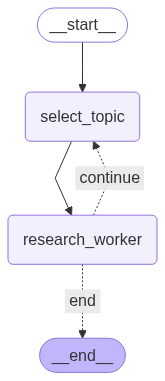

In [101]:
research_worker_graph = create_news_researcher()

class ManagerState(TypedDict):
    topics_to_research: List[str]
    current_topic: str
    results: Annotated[List[str], lambda x, y: x + y]  

def select_topic_node(state: ManagerState):
    """Selects the next topic from the list to be researched."""
    print(f"---MANAGER: {len(state['topics_to_research'])} topics left---")

    topic = state['topics_to_research'][0]
    remaining_topics = state['topics_to_research'][1:]

    return {**state, "current_topic": topic, "topics_to_research": remaining_topics}

def researcher_proxy_node(state: ManagerState):
    """Invokes the worker graph for the current topic."""
    topic = state['current_topic']
    print(f"---MANAGER: DELEGATING '{topic}' TO WORKER---")
    

    worker_response = research_worker_graph.invoke(
        {"messages": [HumanMessage(content=topic)]}
    )
    

    final_answer = worker_response['messages'][-1].content
    
    
    new_result = f"Topic: {topic}\n\n{final_answer}"
    return {**state, "results": state["results"] + [new_result]}

# Define the Manager's router
def manager_router(state: ManagerState):
    """Routes to the end if there are no more topics to research."""
    if not state['topics_to_research']:
        return "end"
    else:
        return "continue"

# Build the Manager graph
manager_builder = StateGraph(ManagerState)
manager_builder.add_node("select_topic", select_topic_node)
manager_builder.add_node("research_worker", researcher_proxy_node)

manager_builder.set_entry_point("select_topic")
manager_builder.add_edge("select_topic", "research_worker")
manager_builder.add_conditional_edges("research_worker", manager_router, {
    "continue": "select_topic",
    "end": END
})

manager_graph = manager_builder.compile()

manager_graph

In [102]:
topics = ["The future of AI hardware", "Recent advancements in large language models"]
initial_state = {"topics_to_research": topics, "results": []}


print("\n---EXECUTING HIERARCHICAL TEAM---")
final_result = manager_graph.invoke(initial_state)

print("\n\n" + "="*80)
print("--- HIERARCHY EXECUTION COMPLETE ---")
print("Collected results:")
for i, result in enumerate(final_result['results']):
    print(f"\n--- RESULT {i+1} ---")
    print(result)


---EXECUTING HIERARCHICAL TEAM---
---MANAGER: 2 topics left---
---MANAGER: DELEGATING 'The future of AI hardware' TO WORKER---
---MANAGER: 1 topics left---
---MANAGER: DELEGATING 'Recent advancements in large language models' TO WORKER---


--- HIERARCHY EXECUTION COMPLETE ---
Collected results:

--- RESULT 1 ---
Topic: The future of AI hardware

AI hardware is expected to move beyond IT and into the Internet of Things. As AI advances, an increasing number of smart devices could become more intelligent, analyzing their usage and taking on new tasks. The true power of hardware could be unlocked when smarter devices become more prevalent.

--- RESULT 2 ---
Topic: The future of AI hardware

AI hardware is expected to move beyond IT and into the Internet of Things. As AI advances, an increasing number of smart devices could become more intelligent, analyzing their usage and taking on new tasks. The true power of hardware could be unlocked when smarter devices become more prevalent.

--- R